## Libraries and constants

In [16]:
# Load project functions
import crypto_monetary_base as cmb

In [163]:
import pandas as pd
import datetime, math
from tqdm.notebook import tqdm
from random import gauss

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set()
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['axes.labelpad'] = 10
mpl.rc('text', usetex=True)
plt.style.use('ggplot')

from IPython.display import display

In [5]:
%load_ext version_information
%version_information pandas, matplotlib, seaborn

Software versions
Python 3.8.6 64bit [GCC 10.2.1 20210110]
IPython 7.19.0
OS Linux 5.10.0 2 amd64 x86_64 with glibc2.29
pandas 1.2.0
matplotlib 3.3.3
seaborn 0.11.1
Sat Feb 13 20:45:24 2021 EST

## Starting simple

Let's start with what Bitcoin did: halving every ~4 years, 99+% of issuance within 30 years, 21M coins total. Bitcoin supply doesn't fully taper off until 2140 but it flattens out by about 2040. Let's analyze it from genesis through the next 30 years, to about 2050.

In [22]:
def btc_block_supply_curve():
    out = [
        # Block num,
        # Total supply,
    ]
    inflation_change_blocks = 210_000
    inflation_change_frac = 0.5
    y = 0
    block = 0
    while block < 2_200_000:
        block += 1
        num_changes = int(
            (block - 1) / inflation_change_blocks
        )
        block_reward = 50 * (
            inflation_change_frac ** num_changes
        )
        y += block_reward
        out.append([block, y])

    return out

In [23]:
start_date_btc = datetime.date(2009, 1, 3)
block_time = datetime.timedelta(seconds=60 * 10)

block_supply = btc_block_supply_curve()

supply = cmb.datetime_supply_curve(
    start_date=start_date_btc,
    block_time=block_time,
    block_supply=block_supply,
)

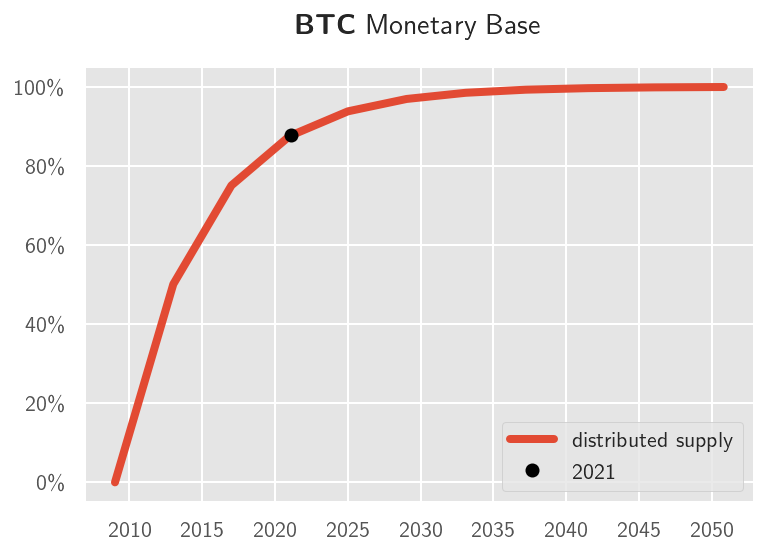

In [24]:
cmb.plot_supply_curve(
    supply,
    'BTC',
);

## Smoothing out the curve

The first and most obvious improvement we can make is to smooth out the curve by replacing periodic halvenings with an exponential decay function. We'll set the half life to 210,000 blocks (~4 years) to match the original curve.

In [25]:
def btc_block_supply_curve_smooth():
    out = [
        # Block num,
        # Total supply,
    ]
    half_life_blocks = 210_000
    tot_supply = 21_000_000
    btc_lambda = math.log(2)/half_life_blocks
    block = 0
    while block < 2_200_000:
        block += 1
        y = tot_supply * (1 - (math.exp(-1 * btc_lambda * block)))
        out.append([block, y])

    return out

In [26]:
block_supply = btc_block_supply_curve_smooth()

supply = cmb.datetime_supply_curve(
    start_date=start_date_btc,
    block_time=block_time,
    block_supply=block_supply,
)

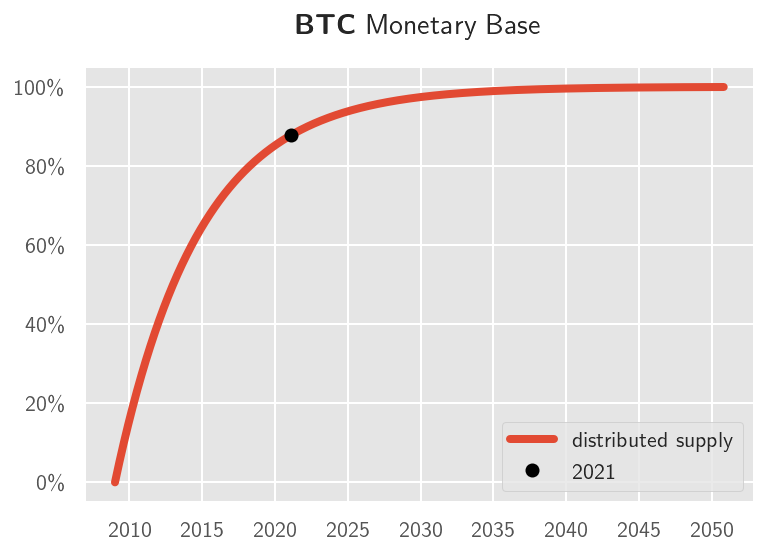

In [27]:
cmb.plot_supply_curve(
    supply,
    'BTC',
);

## Changing the shape of the curve

If we felt that BTC issuance occurred too quickly, we could change the shape of the curve by changing the half-life. Let's see what it would look like with a 6, 8, and 10-year half-life (rather than 4).

In [42]:
def btc_block_supply_curve_smooth():
    out = [
        # Block num,
        # Total supply (4 year half-life),
        # Total supply (6 year half-life),
        # Total supply (8 year half-life),
        # Total supply (10 year half-life),
    ]
    tot_supply = 21_000_000
    btc_lambda_1 = math.log(2)/210_000
    btc_lambda_2 = math.log(2)/315_000
    btc_lambda_3 = math.log(2)/420_000
    btc_lambda_4 = math.log(2)/525_000
    block = 0
    while block < 2_200_000:
        block += 1
        y_1 = tot_supply * (1 - (math.exp(-1 * btc_lambda_1 * block)))
        y_2 = tot_supply * (1 - (math.exp(-1 * btc_lambda_2 * block)))
        y_3 = tot_supply * (1 - (math.exp(-1 * btc_lambda_3 * block)))
        y_4 = tot_supply * (1 - (math.exp(-1 * btc_lambda_4 * block)))
        out.append([block, y_1, y_2, y_3, y_4])

    return out

In [31]:
def datetime_supply_curve(
    start_date,
    block_time,
    block_supply,
    ):
    df = pd.DataFrame(
        block_supply, columns=['block', 'total_supply_1', 'total_supply_2', 'total_supply_3', 'total_supply_4']
    )
    df['total_supply_1_pct'] = (
        df['total_supply_1'] / df['total_supply_1'].values[-1]
        * 100
    )
    df['total_supply_2_pct'] = (
        df['total_supply_2'] / df['total_supply_2'].values[-1]
        * 100
    )
    df['total_supply_3_pct'] = (
        df['total_supply_3'] / df['total_supply_3'].values[-1]
        * 100
    )
    df['total_supply_4_pct'] = (
        df['total_supply_4'] / df['total_supply_4'].values[-1]
        * 100
    )
    df['date'] = pd.date_range(
        start=start_date,
        freq=block_time,
        periods=len(df)
    )
    return df

In [36]:
def plot_supply_curve(
    supply,
    coin_name,
    plot_pct=True,
    max_size=10000,
    fmt='-',
    out_name='',
    ylim=None,
    ):
    max_size = min((max_size, len(supply)))
    step_size = int(len(supply) / max_size)
    dates = mpl.dates.date2num(supply.date.values[::step_size])

    if plot_pct:
        values = supply.total_supply_1_pct.values[::step_size]
    else:
        values = supply.total_supply_1.values[::step_size]
    plt.plot_date(
        dates,
        values,
        fmt=fmt,
        lw=4,
        label='4 year',
    )

    if plot_pct:
        values = supply.total_supply_2_pct.values[::step_size]
    else:
        values = supply.total_supply_2.values[::step_size]
    plt.plot_date(
        dates,
        values,
        fmt=fmt,
        lw=4,
        label='6 year',
    )

    if plot_pct:
        values = supply.total_supply_3_pct.values[::step_size]
    else:
        values = supply.total_supply_3.values[::step_size]
    plt.plot_date(
        dates,
        values,
        fmt=fmt,
        lw=4,
        label='8 year',
    )

    
    if plot_pct:
        values = supply.total_supply_4_pct.values[::step_size]
    else:
        values = supply.total_supply_4.values[::step_size]
    plt.plot_date(
        dates,
        values,
        fmt=fmt,
        lw=4,
        label='10 year',
    )
    
    # Plot current date
    mask = supply.date > datetime.datetime.now()
    current_supply = supply[mask].iloc[0]
    dates = mpl.dates.date2num([current_supply.date])
    if plot_pct:
        values = [current_supply.total_supply_1_pct]
    else:
        values = [current_supply.total_supply_1]
    plt.plot(
        dates,
        values,
        'o',
        color='black',
        ms=6,
        label=current_supply.date.strftime('%Y'),
    )
    if ylim is not None:
        plt.ylim(*ylim)
    
    plt.title(
        r'$\textbf{{{}}}$ Monetary Base'.format(coin_name),
        y=1.05
    )
    plt.legend(loc='lower right')
    ax = plt.gca()
    if plot_pct:
        ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
    
    return plt

In [43]:
block_supply = btc_block_supply_curve_smooth()

supply = datetime_supply_curve(
    start_date=start_date_btc,
    block_time=block_time,
    block_supply=block_supply,
)

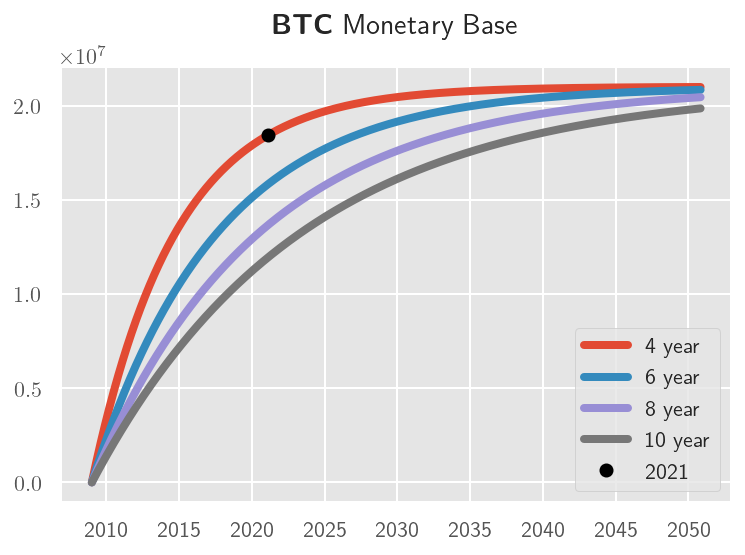

In [44]:
plot_supply_curve(
    supply,
    'BTC',
    plot_pct=False,
);

As the half-life grows, the curve looks more and more linear. It's interesting to note that, due to the logarithmic nature of the curve, even if we more than double the half-life, all the curves still more or less converge at the same point around 2050. We'd have to increase the half-life significantly to extend issuance much further than this.

## Splitting issuance in two

Bitcoin issuance is fixed and has nothing to do with network state, level of security, or network utility. However, we might want to make issuance in Spacemesh contingent upon the amount of spacetime resources committed to the network, at least partially. This directly represents the level of network security and also serves as a reasonable proxy for network utility, as well as overall growth and degree of interest in the project and its ecosystem. Put another way, we may want to defer issuing a portion of coins until the network has achieved certain milestones with respect to maturity. This ensures that it would be attractive for more smeshers to join for a long time after genesis, at least until some minimum desired degree of security or maturity is achieved.

Filecoin introduced this concept and called it ["baseline minting"](https://filecoin.io/blog/filecoin-circulating-supply/) (as opposed to "simple minting", which is fixed regardless of network state, like Bitcoin issuance). The idea is that issuance will be relatively low in the earliest phases of the network, then will increase rapidly as the amount of spacetime committed to the network grows, then will eventually flatten out towards an asymptotic point of maximum issuance (as in Bitcoin).

![Three phases of the Filecoin network](../static/filecoin.png "Filecoin Issuance Model")

### Baseline vs. simple issuance

Here's what the breakdown between simple and baseline issuance looks like in Filecoin, assuming that baseline issuance remains at 70% of total issuance ($\gamma = 0.7$), and that the network achieves its full baseline utilization target. Note that Filecoin issuance uses an exponential decay function (like the second BTC graph above) with a six year half-life.

![Simple vs. baseline issuance in Filecoin](../charts/FIL_simple.png)

### Balancing the two: introducing gamma

The ratio between simple and baseline issuance is set by a parameter called $\gamma$ (gamma). $\gamma$ was set at 0.7 (i.e., 70% contribution from baseline issuance, 30% from simple issuance) for genesis, but it can be moved in the future through governance. This graph shows the effect of gradually increasing $\gamma$ from 0.7 to 1.0, i.e., towards 100% baseline issuance. Note that this causes maximum issuance to be hit fairly quickly.

![The effects of moving gamma](../charts/FIL_complex1.png)

### Effective network time: introducing theta

The purpose of baseline issuance is to set an ever-increasing target for total realized spacetime, and to reduce baseline issuance proportional to how much of that target has been achieved. The above calculations assume that the full target is achieved. In order to calculate how close the network is to its target, Filecoin first calculates cumulative realized network power, a.k.a. "cumulative capped raw-byte power", i.e., realized spacetime, $\overline{R}_\Sigma(t)$. It uses this value to calculate an "effective network time", $\theta(t)$, defined as the solution to the equation

$$\int_0^{\theta(t)} b(x)\space{d}x = \int_0^t \overline{R}(x)\space{d}x = \overline{R}_\Sigma(t)$$

(Full math [here](https://spec.filecoin.io/#section-systems.filecoin_token.block_reward_minting.baseline-minting).)

If the network has achieved 100% target power, effective network time equals current, actual time.

In order to see the effect that $\theta$ has on baseline and total issuance, we can perform a Gaussian random walk on $\theta$ over time using some simple parameters:

This produces the following curve. Even starting at only 20% of the initial baseline target power, with power growing at only 50% of the target growth rate, due to the exponential decay in issuance, total issuance nearly catches up with the 100% baseline after 50 years.

![The effects of varying theta](../charts/FIL_complex2.png)

## Supply Curve Calculation

Given this context, and using a similar approach to Filecoin, what would the SMH issuance curve look like? Let's start with the two [existing, concrete proposals](https://docs.google.com/spreadsheets/d/1jFbyUpsYkwQT-3LPS3L3jBY0Pd26Vkvad6dzNoXHT4Y/edit#gid=1310491469). These proposals entail issuing 4.5M coins over 10 years and 30 years, respectively.

### Some constants

In [133]:
COIN_SYMBOL = 'SMH'
LAYER_TIME = 5 # in minutes
LAYER_TIME_SECS = LAYER_TIME * 60
LAYERS_PER_YEAR = 365.25 * 24 * 60 / LAYER_TIME
TOTAL_SUPPLY = 6_000_000
VAULTED_AMOUNT = 1_500_000
TOTAL_ISSUANCE = TOTAL_SUPPLY - VAULTED_AMOUNT

# For exponential decay calculation
HALF_LIFE_LAYERS = LAYERS_PER_YEAR * 6
SMH_LAMBDA = math.log(2)/HALF_LIFE_LAYERS

"""
`year` is zero-indexed
"""
def yearly_issuance(plan, year):
    ## PLAN 1
    # Aviv's first proposal: ten year issuance, gradually decreasing
    if plan == 1:
        if year >= 10:
            return 0
        slots = sum(x for x in range(1, 11))
        per_slot = TOTAL_ISSUANCE / slots
        return per_slot * (10 - year)

    ## PLAN 2
    # Aviv's second proposal: decreasing issuance each year for first ten years,
    # then minor issuance each year for the next twenty years
    elif plan == 2:
        if year >= 30:
            return 0
        # first ten years, linear issuance to 4M
        elif year < 10:
            slots = sum(x for x in range(1, 11))
            per_slot = 4_000_000 / slots
            return per_slot * (10 - year)
        # 25k per year, next 20 years
        elif year < 30:
            return 25_000;

In [36]:
# Total issuance plan 1
sum(yearly_issuance(1, x) for x in range(10))

4500000.0

In [37]:
# Total issuance plan 2
sum(yearly_issuance(2, x) for x in range(30))

4500000.0

In [49]:
def smh_layer_supply_curve(
    num_layers,
    output_granularity=10_000,
    ):
    out = [
        # Layer num,
        # Total supply - Plan1,
        # Total supply - Plan2,
        # Total supply - Plan3,
    ]
    
    y_1 = y_2 = y_3 = VAULTED_AMOUNT
    layer_reward_plan1 = layer_reward_plan2 = 0

    for layer in tqdm(range(1, num_layers+1)):
        # Adjust layer reward once per year
        if (layer-1) % math.floor(LAYERS_PER_YEAR) == 0:
            current_year = math.floor((layer-1)/LAYERS_PER_YEAR) # 0-indexed

            # If there is no scheduled issuance for this year (i.e., we are beyond the end of
            # the schedule), then set issuance to zero
            year_issuance_plan1 = year_issuance_plan2 = 0
            
            ## PLAN 1: 10-year issuance model
            
            year_issuance_plan1 = yearly_issuance(1, current_year)
            layer_reward_plan1 = year_issuance_plan1/LAYERS_PER_YEAR
            
            ## PLAN 2: 30-year issuance model

            year_issuance_plan2 = yearly_issuance(2, current_year)
            layer_reward_plan2 = year_issuance_plan2/LAYERS_PER_YEAR

        y_1 += layer_reward_plan1
        y_2 += layer_reward_plan2

        ## PLAN 3: exponential decay with six year half-life
        y_3 = VAULTED_AMOUNT + (TOTAL_SUPPLY - VAULTED_AMOUNT) * (1 - (math.exp(-1 * SMH_LAMBDA * layer)))
        
        if (layer-1) % output_granularity == 0:
             out.append([layer, y_1, y_2, y_3])

    return out

In [39]:
def datetime_smh_supply_curve(
    start_date,
    layer_time,
    layer_supply,
    output_granularity=10_000,
    ):
    df = pd.DataFrame(
         layer_supply, columns=['layer', 'plan1', 'plan2', 'plan3']
    )
    df['plan1_pct'] = (
        df['plan1'] / df['plan1'].values[-1]
        * 100
    )
    df['plan2_pct'] = (
        df['plan2'] / df['plan2'].values[-1]
        * 100
    )
    df['plan3_pct'] = (
        df['plan3'] / df['plan3'].values[-1]
        * 100
    )
    df['date'] = pd.date_range(
        start=start_date,
        freq=layer_time * output_granularity,
        periods=len(df)
    )
    return df

In [40]:
def plot_smh_supply_curve(
    supply,
    coin_name='SMH',
    plot_pct=False,
    max_size=10_000,
    out_name='',
    ):
    max_size = min((max_size, len(supply)))
    step_size = int(len(supply) / max_size)
    dates = mpl.dates.date2num(supply.date.values[::step_size])
    
    # Plan1
    if plot_pct:
        values = supply.plan1_pct.values[::step_size]
    else:
        values = supply.plan1.values[::step_size]
    plt.plot_date(
        dates,
        values,
#         fmt='-',
        lw=4,
        label='plan1',
    )
    
    # Plan2
    if plot_pct:
        values = supply.plan2_pct.values[::step_size]
    else:
        values = supply.plan2.values[::step_size]
    plt.plot_date(
        dates,
        values,
#         fmt='-',
        lw=4,
        label='plan2',
#         color='orange',
    )
    
    # Plan3
    if plot_pct:
        values = supply.plan3_pct.values[::step_size]
    else:
        values = supply.plan3.values[::step_size]
    plt.plot_date(
        dates,
        values,
#         fmt='.',
        lw=4,
        label='exponential-decay',
#         color='green',
    )
    
    plt.title(
        fr'$\textbf{{{coin_name}}}$ Monetary Base',
        y=1.05
    )
    plt.legend()
    
    ax = plt.gca()
    if plot_pct:
        ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
    
#     if not out_name:
#         out_name = coin_name
#     plt.savefig(
#         f'../charts/{out_name}.png',
#         bbox_inches='tight',
#         dpi=300
#     )
    return plt

In [134]:
START_DATE = datetime.date(2021, 7, 1)
END_DATE = datetime.date(2140, 10, 7)

num_layers = int(
    ((END_DATE - START_DATE).days * 24 * 3600)
    / LAYER_TIME_SECS
)

layer_supply = smh_layer_supply_curve(
    num_layers=num_layers,
)

supply = datetime_smh_supply_curve(
    start_date=START_DATE,
    layer_time=layer_time,
    layer_supply=layer_supply,
)

  0%|          | 0/12545856 [00:00<?, ?it/s]

In [51]:
display(supply.head())
display(supply.tail())

,layer,plan1,plan2,plan3,plan1_pct,plan2_pct,plan3_pct,date
0,1,1.500008e+06,1.500007e+06,1.500005e+06,25.000130,25.000115,25.000102,2021-07-01 00:00:00
1,10001,1.577788e+06,1.569145e+06,1.549155e+06,26.296460,26.152409,25.819264,2021-08-04 17:20:00
2,20001,1.655567e+06,1.638282e+06,1.597768e+06,27.592791,27.304703,26.629480,2021-09-08 10:40:00
3,30001,1.733347e+06,1.707420e+06,1.645849e+06,28.889122,28.456998,27.430846,2021-10-13 04:00:00
4,40001,1.811127e+06,1.776557e+06,1.693406e+06,30.185453,29.609292,28.223459,2021-11-16 21:20:00


,layer,plan1,plan2,plan3,plan1_pct,plan2_pct,plan3_pct,date
1250,12500001,6.000000e+06,6.000000e+06,5.999995e+06,100.0,100.0,99.999996,2140-04-30 18:40:00
1251,12510001,6.000000e+06,6.000000e+06,5.999995e+06,100.0,100.0,99.999997,2140-06-04 12:00:00
1252,12520001,6.000000e+06,6.000000e+06,5.999995e+06,100.0,100.0,99.999998,2140-07-09 05:20:00
1253,12530001,6.000000e+06,6.000000e+06,5.999995e+06,100.0,100.0,99.999999,2140-08-12 22:40:00
1254,12540001,6.000000e+06,6.000000e+06,5.999995e+06,100.0,100.0,100.000000,2140-09-16 16:00:00


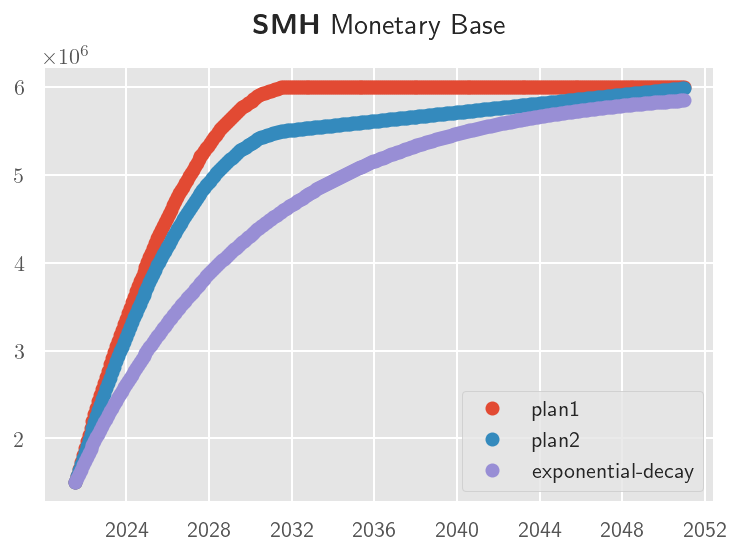

In [52]:
mask = supply.date < datetime.datetime(2051, 1, 1)
plot_smh_supply_curve(supply[mask]);

For comparison, you can see the two plans here plotted against an exponential decay function with a six year half-life (similar to what FIL uses). As we can see, these plans are both much more aggressive than FIL (or BTC) issuance: they're faster and steeper.

However, this graph is a little bit misleading since the coins locked up in vaults at genesis haven't vested and aren't liquid. Let's factor that in, and look at how it impacts the exponential decay curve.

In [74]:
def smh_layer_supply_curve_2(
    num_layers,
    output_granularity=10_000,
    ):
    out = [
        # Layer num,
        # Smeshing rewards,
        # Authorized vault amounts (including unvested),
        # Issued vault amounts (only vested),
    ]

    y_1 = y_2 = y_3 = 0

    for layer in tqdm(range(1, num_layers+1)):
        # 100% of the vaulted amount is authorized as of genesis, so this math is easy
        y_1 = (TOTAL_SUPPLY - VAULTED_AMOUNT) * (1 - (math.exp(-1 * SMH_LAMBDA * layer)))
        
        y_2 = VAULTED_AMOUNT

        # but coins in vaults are not liquid nor spendable at genesis.
        # this math needs to factor in vesting of vaults: 1 year cliff, 4 year total vest
        
        # one year cliff
        y_3 = VAULTED_AMOUNT/5 if layer-1 >= int(LAYERS_PER_YEAR) else 0
        
        # approximate linear vesting after that, from zero up to four more years
        y_3 += max(min((layer-1)/LAYERS_PER_YEAR, 5)-1, 0)*VAULTED_AMOUNT/5
        
        if (layer-1) % output_granularity == 0:
             out.append([layer, y_1, y_2, y_3])

    return out

In [71]:
def datetime_smh_supply_curve_2(
    start_date,
    layer_time,
    layer_supply,
    output_granularity=10_000,
    ):
    df = pd.DataFrame(
         layer_supply, columns=['layer', 'smeshing', 'vault1', 'vault2']
    )
    df['smeshing_pct'] = (
        df['smeshing'] / df['smeshing'].values[-1]
        * 100
    )
    df['vault1_pct'] = (
        df['vault1'] / df['vault1'].values[-1]
        * 100
    )
    df['vault2_pct'] = (
        df['vault2'] / df['vault2'].values[-1]
        * 100
    )
    df['total_authorized'] = df['smeshing'] + df['vault1']
    df['total_issued'] = df['smeshing'] + df['vault2']
    df['total_authorized_pct'] = (
        df['total_authorized'] / df['total_authorized'].values[-1]
        * 100
    )
    df['total_issued_pct'] = (
        df['total_issued'] / df['total_issued'].values[-1]
        * 100
    )
    df['date'] = pd.date_range(
        start=start_date,
        freq=layer_time * output_granularity,
        periods=len(df)
    )
    return df

In [91]:
def plot_smh_supply_curve_2(
    supply,
    coin_name='SMH',
    plot_pct=False,
    max_size=10_000,
    out_name='',
    ):
    max_size = min((max_size, len(supply)))
    step_size = int(len(supply) / max_size)
    dates = mpl.dates.date2num(supply.date.values[::step_size])
    
    # Total - authorized
    if plot_pct:
        values = supply.total_authorized_pct.values[::step_size]
    else:
        values = supply.total_authorized.values[::step_size]
    plt.plot_date(
        dates,
        values,
        lw=4,
        label='total-authorized',
    )

    # Total - issued
    if plot_pct:
        values = supply.total_issued_pct.values[::step_size]
    else:
        values = supply.total_issued.values[::step_size]
    plt.plot_date(
        dates,
        values,
        lw=4,
        label='total-issued',
    )
    
    # Smeshing
    if plot_pct:
        values = supply.smeshing_pct.values[::step_size]
    else:
        values = supply.smeshing.values[::step_size]
    plt.plot_date(
        dates,
        values,
        lw=4,
        fmt='--',
        label='smeshers',
    )
    
    # Vault - authorized (incl. unvested)
    if plot_pct:
        values = supply.vault1_pct.values[::step_size]
    else:
        values = supply.vault1.values[::step_size]
    plt.plot_date(
        dates,
        values,
        lw=4,
        fmt='--',
        label='vault-all',
    )
    
    # Vault - issued (vested)
    if plot_pct:
        values = supply.vault2_pct.values[::step_size]
    else:
        values = supply.vault2.values[::step_size]
    plt.plot_date(
        dates,
        values,
        lw=4,
        fmt='--',
        label='vault-vested',
    )
    
    plt.title(
        fr'$\textbf{{{coin_name}}}$ Monetary Base',
        y=1.05
    )
    plt.legend()
    
    ax = plt.gca()
    if plot_pct:
        ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
    
#     if not out_name:
#         out_name = coin_name
#     plt.savefig(
#         f'../charts/{out_name}.png',
#         bbox_inches='tight',
#         dpi=300
#     )
    return plt

In [119]:
def plot_smh_supply_curve_stackplot(
    supply,
    coin_name='SMH',
    plot_pct=False,
    max_size=10_000,
    out_name='',
    ):
    import matplotlib.dates as mdates
    
    # date formatting
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    yearsFmt = mdates.DateFormatter('%Y')

    max_size = min((max_size, len(supply)))
    step_size = int(len(supply) / max_size)
    dates = mpl.dates.date2num(supply.date.values[::step_size])
    
    # Smeshing
    y_1 = supply.smeshing.values[::step_size]
    
    # Vault - issued (vested)
    y_2 = supply.vault2.values[::step_size]
    
    plt.stackplot(dates, y_1, y_2, labels=[
        'smeshing',
        'vault-vested',
    ])
    
    plt.title(
        fr'$\textbf{{{coin_name}}}$ Monetary Base',
        y=1.05
    )
    plt.legend()
    ax = plt.gca()
    
#     # format the ticks
    ax.xaxis.set_minor_locator(years)
    ax.xaxis.set_major_formatter(yearsFmt)
#     ax.xaxis.set_minor_locator(months)

#     datemin = datetime.date(pd.DatetimeIndex(supply.date).year[0], 1, 1)
#     datemax = datetime.date(pd.DatetimeIndex(supply.date).year[-1] + 1, 1, 1)
#     ax.set_xlim(datemin, datemax)
    
    return plt

In [75]:
num_layers = int(
    ((END_DATE - START_DATE).days * 24 * 3600)
    / LAYER_TIME_SECS
)

layer_supply = smh_layer_supply_curve_2(
    num_layers=num_layers,
)

supply = datetime_smh_supply_curve_2(
    start_date=start_date,
    layer_time=layer_time,
    layer_supply=layer_supply,
)

  0%|          | 0/12545856 [00:00<?, ?it/s]

In [76]:
display(supply.head())
display(supply.tail())

,layer,smeshing,vault1,vault2,smeshing_pct,vault1_pct,vault2_pct,total_authorized,total_issued,total_authorized_pct,total_issued_pct,date
0,1,4.942012,1500000,0.0,0.000110,100.0,0.0,1.500005e+06,4.942012,25.000102,0.000082,2021-07-01 00:00:00
1,10001,49154.651072,1500000,0.0,1.092327,100.0,0.0,1.549155e+06,49154.651072,25.819264,0.819245,2021-08-04 17:20:00
2,20001,97767.538677,1500000,0.0,2.172614,100.0,0.0,1.597768e+06,97767.538677,26.629480,1.629460,2021-09-08 10:40:00
3,30001,145849.468080,1500000,0.0,3.241103,100.0,0.0,1.645849e+06,145849.468080,27.430846,2.430826,2021-10-13 04:00:00
4,40001,193406.238497,1500000,0.0,4.297921,100.0,0.0,1.693406e+06,193406.238497,28.223459,3.223440,2021-11-16 21:20:00


,layer,smeshing,vault1,vault2,smeshing_pct,vault1_pct,vault2_pct,total_authorized,total_issued,total_authorized_pct,total_issued_pct,date
1250,12500001,4.499995e+06,1500000,1500000.0,99.999995,100.0,100.0,5.999995e+06,5.999995e+06,99.999996,99.999996,2140-04-30 18:40:00
1251,12510001,4.499995e+06,1500000,1500000.0,99.999997,100.0,100.0,5.999995e+06,5.999995e+06,99.999997,99.999997,2140-06-04 12:00:00
1252,12520001,4.499995e+06,1500000,1500000.0,99.999998,100.0,100.0,5.999995e+06,5.999995e+06,99.999998,99.999998,2140-07-09 05:20:00
1253,12530001,4.499995e+06,1500000,1500000.0,99.999999,100.0,100.0,5.999995e+06,5.999995e+06,99.999999,99.999999,2140-08-12 22:40:00
1254,12540001,4.499995e+06,1500000,1500000.0,100.000000,100.0,100.0,5.999995e+06,5.999995e+06,100.000000,100.000000,2140-09-16 16:00:00


In [77]:
#plot_smh_supply_curve(supply)

In [78]:
#plot_smh_supply_curve(supply, plot_pct=True)

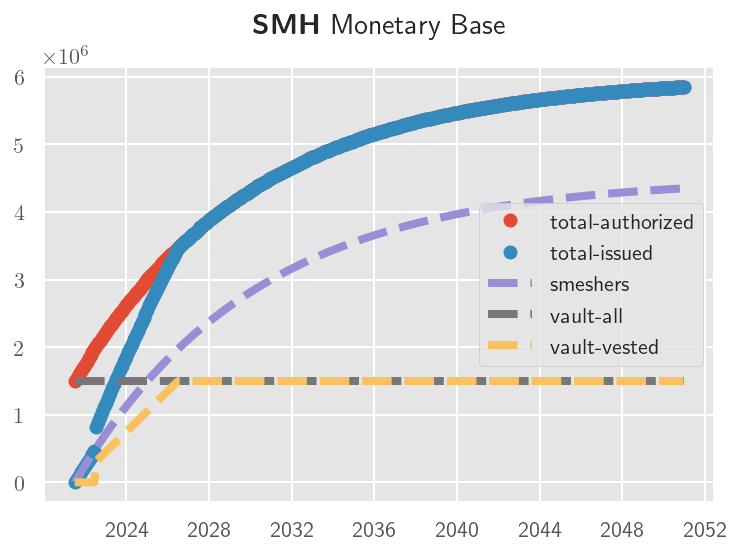

In [92]:
mask = supply.date < datetime.datetime(2051, 1, 1)
plot_smh_supply_curve_2(supply[mask])

<module 'matplotlib.pyplot' from '/home/lane/.local/share/virtualenvs/crypto-monetary-base-xxmj4jsc/lib/python3.8/site-packages/matplotlib/pyplot.py'>

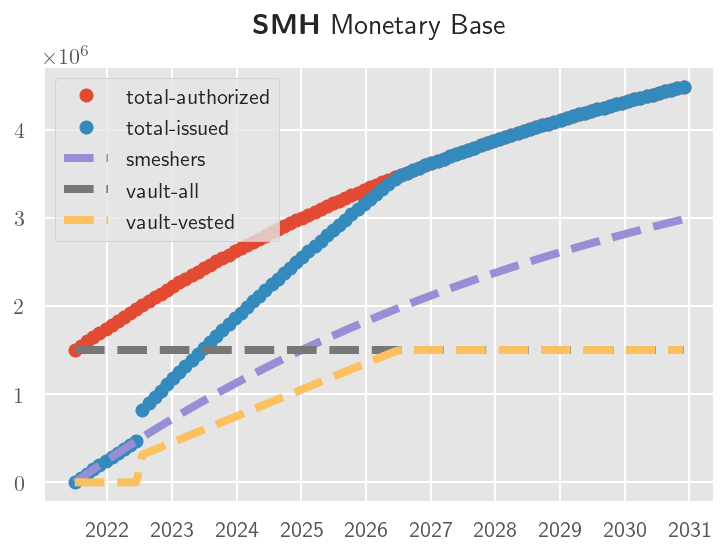

In [105]:
mask = supply.date < datetime.datetime(2031, 1, 1)
plot_smh_supply_curve_2(supply[mask])

The red curve represents the number of coins that have been "authorized," which includes the full portion in vaults reserved for investors and team (in addition to rewards issued to smeshers). The blue curve represents the number of coins that have actually been issued (and are tradeable), including only the _vested_ portion of vaults. The discontinuity in the blue curve represents the end of the one-year vesting cliff.

Here's a stackplot of the breakdown of issuance over time:

<module 'matplotlib.pyplot' from '/home/lane/.local/share/virtualenvs/crypto-monetary-base-xxmj4jsc/lib/python3.8/site-packages/matplotlib/pyplot.py'>

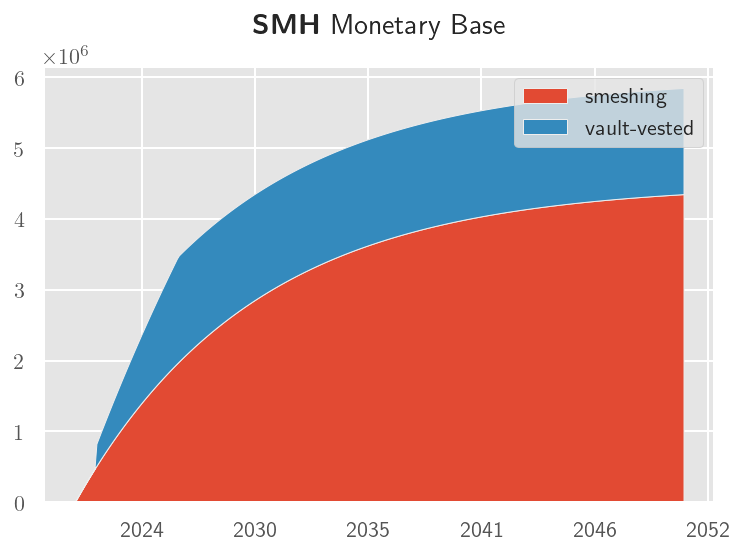

In [120]:
mask = supply.date < datetime.datetime(2051, 1, 1)
plot_smh_supply_curve_stackplot(supply[mask])

## One final curve

Putting it all together: including baseline target, vault allocations, vesting, and a hypothetical community fund.

In [303]:
# Some useful constants

# Lambda drives the exponential decay: use a six year half-life
# LAMBDA = math.log(2)/(6*EPOCH_PER_YEAR)
LAMBDA = SMH_LAMBDA

# Initial params

TOTAL_MINTING = TOTAL_SUPPLY - VAULTED_AMOUNT

# Display ticks, in layers, 288 layers per day, 1,000 layers =~ 3.5 days
OUTPUT_GRANULARITY = 1000

# Initial baseline target = 1EB
# See https://en.wikipedia.org/wiki/Byte#Multiple-byte_units
# https://en.wikipedia.org/wiki/Orders_of_magnitude_(data)
BASELINE_INITIAL_VALUE = 1_000_000_000_000_000_000

# baseline annual growth rate = 100%
BASELINE_ANNUAL_G = 1

# used in the equation to calculate effective network time
# wrt layer (which is what E.N.T. is denominated in)
BASELINE_G = math.log(1 + BASELINE_ANNUAL_G)/LAYERS_PER_YEAR

# Simulate evolution in effective network time as a Gaussian random walk with these params.
INITIAL_POWER = BASELINE_INITIAL_VALUE * 0.2 # Start at X% of target
GAUSSIAN_ANNUAL_G = 0.1 * BASELINE_ANNUAL_G # % of target growth each year
GAUSSIAN_GRANULARITY = OUTPUT_GRANULARITY # adjust once per display tick (~3.5 days)
GAUSSIAN_MEAN = math.log(1 + GAUSSIAN_ANNUAL_G)*GAUSSIAN_GRANULARITY/LAYERS_PER_YEAR
GAUSSIAN_STDEV = 0.68 * GAUSSIAN_MEAN # normal distribution

# γ is the mixture between baseline and simple minting.
# A γ value of 1.0 corresponds to pure baseline minting,
# while a γ value of 0.0 corresponds to pure simple minting.
GAMMA_INITIAL = 0.7

# A hypothetical community fund that receives some percentage of all issuance
COMFUND_RATIO = 0.05 # % of all issuance

In [228]:
# Recalculate breakdown between simple and baseline as gamma changes
def compute_simple_total(gamma):
    return TOTAL_MINTING * (1-gamma)

def compute_baseline_total(gamma):
    return TOTAL_MINTING * gamma

# Effective network time is a function of initial baseline, baseline growth, and
# realized cumsum (cumulative capped raw-byte power, i.e., realized spacetime, bytes x epochs).
def compute_effective_network_time(cumsumRealized):
    return (1/BASELINE_G)*math.log((BASELINE_G*cumsumRealized/BASELINE_INITIAL_VALUE)+1)

# Baseline supply at effective network time theta
def compute_baseline_supply(theta, gamma):
    return compute_baseline_total(gamma) * (1 - (math.exp(-1 * theta * LAMBDA)))

def compute_simple_supply(layer, gamma):
    return compute_simple_total(gamma) * (1 - math.exp(-1 * layer * LAMBDA))

In [246]:
def smh_layer_supply_curve_3(
    num_layers,
    output_granularity=OUTPUT_GRANULARITY,
    ):
    out = [
        # Layer num,
        # Smeshing rewards (simple),
        # Smeshing rewards (baseline, random walk),
        # Authorized vault amounts (including unvested),
        # Issued vault amounts (only vested),
    ]
    
    currPower = INITIAL_POWER
    cumsumRealized = 0
    y_1 = y_2 = y_3 = y_4 = y_5 = 0

    for layer in tqdm(range(1, num_layers+1)):
        if (layer-1) % output_granularity == 0:
            ## 1. SIMPLE ISSUANCE
            simple = compute_simple_supply(layer, GAMMA_INITIAL)
            y_1 = simple * (1 - COMFUND_RATIO)

            ## 2. BASELINE ISSUANCE
            theta = min(compute_effective_network_time(cumsumRealized), layer)
            baseline = compute_baseline_supply(theta, GAMMA_INITIAL)
            print(
                f'Layer is {layer}, '
                f'Theta is {theta}, '
                f'CurrPower is {currPower}, '
                f'CumsumRealized is {cumsumRealized}, '
                f'Baseline is {baseline}'
            )
            y_2 = baseline * (1 - COMFUND_RATIO)

            # Model effective network time using a Gaussian random walk
            currPower *= (1+gauss(GAUSSIAN_MEAN, GAUSSIAN_STDEV))
            cumsumRealized += currPower * output_granularity # add spacetime (bytes x layers)

            ## 3. VAULT AMOUNTS (incl. unvested)
            y_3 = VAULTED_AMOUNT

            ## 4. VAULT AMOUNTS (only vested)

            # coins in vaults are not liquid nor spendable at genesis.
            # this math needs to factor in vesting of vaults: 1 year cliff, 4 year total vest

            # one year cliff
            y_4 = VAULTED_AMOUNT/5 if layer-1 >= int(LAYERS_PER_YEAR) else 0

            # approximate linear vesting after that, from zero up to four more years
            y_4 += max(min((layer-1)/LAYERS_PER_YEAR, 5)-1, 0)*VAULTED_AMOUNT/5
            
            ## 5. COMMUNITY FUND (hypothetical)
            y_5 = COMFUND_RATIO * (simple + baseline)

            out.append([layer, theta, y_1, y_2, y_3, y_4, y_5])

    return out

In [276]:
def datetime_smh_supply_curve_3(
    start_date,
    layer_time,
    supply,
    output_granularity=OUTPUT_GRANULARITY,
    ):
    df = pd.DataFrame(
         supply, columns=['layer', 'theta', 'simple', 'baseline', 'vault1', 'vault2', 'comfund']
    )
    df['theta_pct'] = (
        df['theta'] / df['layer']
        * 100
    )
    df['simple_pct'] = (
        df['simple'] / df['simple'].values[-1]
        * 100
    )
    df['baseline_pct'] = (
        df['baseline'] / df['baseline'].values[-1]
        * 100
    )
    df['vault1_pct'] = (
        df['vault1'] / df['vault1'].values[-1]
        * 100
    )
    df['vault2_pct'] = (
        df['vault2'] / df['vault2'].values[-1]
        * 100
    )
    df['comfund_pct'] = (
        df['comfund'] / df['comfund'].values[-1]
        * 100
    )
    df['total_authorized'] = df['simple'] + df['baseline'] + df['comfund'] + df['vault1']
    df['total_issued'] = df['simple'] + df['baseline'] + df['comfund'] + df['vault2']
    df['total_authorized_pct'] = (
        df['total_authorized'] / df['total_authorized'].values[-1]
        * 100
    )
    df['total_issued_pct'] = (
        df['total_issued'] / df['total_issued'].values[-1]
        * 100
    )
    df['date'] = pd.date_range(
        start=start_date,
        freq=layer_time * output_granularity,
        periods=len(df)
    )
    return df

In [291]:
def plot_theta(
    supply,
    coin_name='SMH',
    plot_pct=False,
    max_size=10_000,
    out_name='',
    ):
    max_size = min((max_size, len(supply)))
    step_size = int(len(supply) / max_size)
    # skip first tick in pct mode since theta = 0 so it's 0% then jumps
    start_tick = 1 if plot_pct else 0
    label = r'$\theta/layer$' if plot_pct else r'$\theta$'
    title = 'Effective Network Time'
    if plot_pct:
        title += ' (Relative)'

    if plot_pct:
        values = supply.theta_pct.values[start_tick::step_size]
    else:
        values = supply.theta.values[start_tick::step_size]
    plt.plot(
        supply.layer.values[start_tick::step_size],
        values,
        lw=4,
        label=label,
    )

    plt.title(
        fr'$\textbf{{{coin_name}}}$ {title}',
        y=1.05
    )
    plt.legend()

    ax = plt.gca()
    if plot_pct:
        ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())

    return plt

In [292]:
def plot_smh_supply_curve_3(
    supply,
    coin_name='SMH',
    plot_pct=False,
    max_size=10_000,
    out_name='',
    ):
    max_size = min((max_size, len(supply)))
    step_size = int(len(supply) / max_size)
    dates = mpl.dates.date2num(supply.date.values[::step_size])
    
    # Total - authorized
    if plot_pct:
        values = supply.total_authorized_pct.values[::step_size]
    else:
        values = supply.total_authorized.values[::step_size]
    plt.plot_date(
        dates,
        values,
        lw=4,
        label='total-authorized',
    )

    # Total - issued
    if plot_pct:
        values = supply.total_issued_pct.values[::step_size]
    else:
        values = supply.total_issued.values[::step_size]
    plt.plot_date(
        dates,
        values,
        lw=4,
        label='total-issued',
    )

    # Simple
    if plot_pct:
        values = supply.simple_pct.values[::step_size]
    else:
        values = supply.simple.values[::step_size]
    plt.plot_date(
        dates,
        values,
        lw=4,
        fmt='--',
        label='simple',
    )
    
    # Baseline
    if plot_pct:
        values = supply.baseline_pct.values[::step_size]
    else:
        values = supply.baseline.values[::step_size]
    plt.plot_date(
        dates,
        values,
        lw=4,
        fmt='--',
        label='baseline',
    )
    
    # Vault - authorized (incl. unvested)
    if plot_pct:
        values = supply.vault1_pct.values[::step_size]
    else:
        values = supply.vault1.values[::step_size]
    plt.plot_date(
        dates,
        values,
        lw=4,
        fmt='--',
        label='vault-all',
    )
    
    # Vault - issued (vested)
    if plot_pct:
        values = supply.vault2_pct.values[::step_size]
    else:
        values = supply.vault2.values[::step_size]
    plt.plot_date(
        dates,
        values,
        lw=4,
        fmt='--',
        label='vault-vested',
    )

    # Community fund
    if plot_pct:
        values = supply.comfund_pct.values[::step_size]
    else:
        values = supply.comfund.values[::step_size]
    plt.plot_date(
        dates,
        values,
        lw=4,
        fmt='--',
        label='fund',
    )
    
    plt.title(
        fr'$\textbf{{{coin_name}}}$ Monetary Base',
        y=1.05
    )
    plt.legend()
    
    ax = plt.gca()
    if plot_pct:
        ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
    
    if not out_name:
        out_name = coin_name
    plt.savefig(
        f'../charts/{out_name}.png',
        bbox_inches='tight',
        dpi=300
    )
    return plt

In [293]:
def plot_smh_supply_curve_stackplot_3(
    supply,
    coin_name='SMH',
    plot_pct=False,
    max_size=10_000,
    out_name='',
    ):
    import matplotlib.dates as mdates
    
    # date formatting
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    yearsFmt = mdates.DateFormatter('%Y')

    max_size = min((max_size, len(supply)))
    step_size = int(len(supply) / max_size)
    dates = mpl.dates.date2num(supply.date.values[::step_size])
    
    # Simple
    y_1 = supply.simple.values[::step_size]
    
    # Baseline
    y_2 = supply.baseline.values[::step_size]
    
    # Vault - issued (vested)
    y_3 = supply.vault2.values[::step_size]
    
    # Community fund
    y_4 = supply.comfund.values[::step_size]
    
    plt.stackplot(dates, y_1, y_2, y_3, y_4, labels=[
        'simple',
        'baseline',
        'vault-vested',
        'fund',
    ])
    
    plt.title(
        fr'$\textbf{{{coin_name}}}$ Monetary Base',
        y=1.05
    )
    plt.legend(loc='upper left')
    ax = plt.gca()
    
#     # format the ticks
    ax.xaxis.set_minor_locator(years)
    ax.xaxis.set_major_formatter(yearsFmt)
#     ax.xaxis.set_minor_locator(months)

#     datemin = datetime.date(pd.DatetimeIndex(supply.date).year[0], 1, 1)
#     datemax = datetime.date(pd.DatetimeIndex(supply.date).year[-1] + 1, 1, 1)
#     ax.set_xlim(datemin, datemax)
    
    return plt

In [304]:
num_layers = int(
    ((END_DATE - START_DATE).days * 24 * 3600)
    / LAYER_TIME_SECS
)
layer_time = datetime.timedelta(seconds=LAYER_TIME_SECS)

supply = smh_layer_supply_curve_3(num_layers=num_layers)

print(
    f'Start date: {START_DATE}, '
    f'End date: {END_DATE}, '
    f'Layer time: {layer_time}, '
    f'Num layers: {num_layers}'
)

supply = datetime_smh_supply_curve_3(
    start_date=START_DATE,
    layer_time=layer_time,
    supply=supply,
)

  0%|          | 0/12545856 [00:00<?, ?it/s]

Layer is 1, Theta is 0.0, CurrPower is 2e+17, CumsumRealized is 0, Baseline is 0.0
Layer is 1001, Theta is 199.93391992365366, CurrPower is 2.0006567775984432e+17, CumsumRealized is 2.0006567775984432e+20, Baseline is 691.5774982878709
Layer is 2001, Theta is 399.8125659241754, CurrPower is 2.0027400525788547e+17, CumsumRealized is 4.003396830177298e+20, Baseline is 1382.812030611863
Layer is 3001, Theta is 599.745159422253, CurrPower is 2.0059211520616784e+17, CumsumRealized is 6.009317982238976e+20, Baseline is 2074.081349085166
Layer is 4001, Theta is 799.7971013492297, CurrPower is 2.009765337231638e+17, CumsumRealized is 8.019083319470614e+20, Baseline is 2765.611414181812
Layer is 5001, Theta is 999.7979185253776, CurrPower is 2.0119017557121738e+17, CumsumRealized is 1.0030985075182788e+21, Baseline is 3456.812897950312
Layer is 6001, Theta is 1199.7386832109996, CurrPower is 2.013949649175285e+17, CumsumRealized is 1.2044934724358072e+21, Baseline is 4147.655106115894
Layer is 

Layer is 682001, Theta is 122276.80768218756, CurrPower is 3.691382687627084e+17, CumsumRealized is 1.8792721680444524e+23, Baseline is 395833.2345579906
Layer is 683001, Theta is 122441.77382413967, CurrPower is 3.694475621463954e+17, CumsumRealized is 1.8829666436659163e+23, Baseline is 396332.16179059626
Layer is 684001, Theta is 122606.82840313147, CurrPower is 3.700477585731304e+17, CumsumRealized is 1.8866671212516475e+23, Baseline is 396831.2660389766
Layer is 685001, Theta is 122771.80292272024, CurrPower is 3.702706585483175e+17, CumsumRealized is 1.8903698278371306e+23, Baseline is 397330.0378006167
Layer is 686001, Theta is 122936.6313293966, CurrPower is 3.703449170316294e+17, CumsumRealized is 1.894073277007447e+23, Baseline is 397828.277576395
Layer is 687001, Theta is 123101.48089184758, CurrPower is 3.707949831729487e+17, CumsumRealized is 1.8977812268391763e+23, Baseline is 398326.49110145523
Layer is 688001, Theta is 123266.37941880678, CurrPower is 3.713082939055352e

Layer is 1472001, Theta is 245098.16876376045, CurrPower is 7.375205312417551e+17, CumsumRealized is 6.113013717002976e+23, Baseline is 743365.2328182434
Layer is 1473001, Theta is 245244.925501807, CurrPower is 7.382615662649315e+17, CumsumRealized is 6.120396332665625e+23, Baseline is 743753.0836590447
Layer is 1474001, Theta is 245391.61115564033, CurrPower is 7.386177250665711e+17, CumsumRealized is 6.12778250991629e+23, Baseline is 744140.684177207
Layer is 1475001, Theta is 245538.1936192144, CurrPower is 7.388116354738454e+17, CumsumRealized is 6.135170626271029e+23, Baseline is 744527.9496573997
Layer is 1476001, Theta is 245684.73232303248, CurrPower is 7.393047065456315e+17, CumsumRealized is 6.142563673336485e+23, Baseline is 744915.0372166287
Layer is 1477001, Theta is 245831.27123220873, CurrPower is 7.400199579380535e+17, CumsumRealized is 6.149963872915866e+23, Baseline is 745302.0630282196
Layer is 1478001, Theta is 245977.83900520252, CurrPower is 7.40880837010859e+17,

Layer is 2059001, Theta is 329888.75598070206, CurrPower is 1.2585351301742728e+18, CumsumRealized is 1.1823951546784732e+24, Baseline is 957351.3772009223
Layer is 2060001, Theta is 330031.98934951716, CurrPower is 1.2597902682284475e+18, CumsumRealized is 1.1836549449467016e+24, Baseline is 957696.2592482825
Layer is 2061001, Theta is 330175.2843920784, CurrPower is 1.2615230505888067e+18, CumsumRealized is 1.1849164679972904e+24, Baseline is 958041.2355141388
Layer is 2062001, Theta is 330318.6360032477, CurrPower is 1.2632134879833805e+18, CumsumRealized is 1.1861796814852737e+24, Baseline is 958386.2936494519
Layer is 2063001, Theta is 330462.03279171453, CurrPower is 1.264805942566579e+18, CumsumRealized is 1.1874444874278404e+24, Baseline is 958731.406185197
Layer is 2064001, Theta is 330605.41103499767, CurrPower is 1.2658378058956122e+18, CumsumRealized is 1.1887103252337359e+24, Baseline is 959076.4197541233
Layer is 2065001, Theta is 330748.83892000647, CurrPower is 1.267473

Layer is 2620001, Theta is 409880.7249358887, CurrPower is 2.097996427859767e+18, CumsumRealized is 2.1083049040362557e+24, Baseline is 1141755.3845133637
Layer is 2621001, Theta is 410021.62482661684, CurrPower is 2.099306910510573e+18, CumsumRealized is 2.1104042109467662e+24, Baseline is 1142066.115929926
Layer is 2622001, Theta is 410162.4675784718, CurrPower is 2.10040437982481e+18, CumsumRealized is 2.112504615326591e+24, Baseline is 1142376.6732865793
Layer is 2623001, Theta is 410303.4427947512, CurrPower is 2.1043328014358374e+18, CumsumRealized is 2.1146089481280268e+24, Baseline is 1142687.474626256
Layer is 2624001, Theta is 410444.22518991865, CurrPower is 2.1034062525852767e+18, CumsumRealized is 2.116712354380612e+24, Baseline is 1142997.8028457481
Layer is 2625001, Theta is 410585.14161637914, CurrPower is 2.10736374239705e+18, CumsumRealized is 2.118819718123009e+24, Baseline is 1143308.3784670092
Layer is 2626001, Theta is 410726.06934721576, CurrPower is 2.1094907288

Layer is 3284001, Theta is 502517.3176727387, CurrPower is 3.8167934022482263e+18, CumsumRealized is 4.0094616690888623e+24, Baseline is 1336016.6874453875
Layer is 3285001, Theta is 502656.5260881417, CurrPower is 3.8188121048481736e+18, CumsumRealized is 4.0132804811937105e+24, Baseline is 1336293.992048212
Layer is 3286001, Theta is 502795.63823727355, CurrPower is 3.819672238944945e+18, CumsumRealized is 4.0171001534326555e+24, Baseline is 1336571.0625398865
Layer is 3287001, Theta is 502934.54478249326, CurrPower is 3.817522047511777e+18, CumsumRealized is 4.020917675480167e+24, Baseline is 1336847.681296191
Layer is 3288001, Theta is 503073.51429478003, CurrPower is 3.8227507217568404e+18, CumsumRealized is 4.0247404262019244e+24, Baseline is 1337124.3832213706
Layer is 3289001, Theta is 503212.6311397725, CurrPower is 3.8303112675239404e+18, CumsumRealized is 4.028570737469448e+24, Baseline is 1337401.3362062548
Layer is 3290001, Theta is 503351.8508548392, CurrPower is 3.836660

Layer is 3947001, Theta is 594503.8932855567, CurrPower is 6.886205187691292e+18, CumsumRealized is 7.477117225754146e+24, Baseline is 1510316.6314103454
Layer is 3948001, Theta is 594641.0212694061, CurrPower is 6.896451550171139e+18, CumsumRealized is 7.484013677304316e+24, Baseline is 1510563.5449351452
Layer is 3949001, Theta is 594778.2202280591, CurrPower is 6.906260206551593e+18, CumsumRealized is 7.490919937510868e+24, Baseline is 1510810.5490470144
Layer is 3950001, Theta is 594915.5665247422, CurrPower is 6.919933354217387e+18, CumsumRealized is 7.497839870865085e+24, Baseline is 1511057.7811421196
Layer is 3951001, Theta is 595052.7226045037, CurrPower is 6.916602156602912e+18, CumsumRealized is 7.504756473021688e+24, Baseline is 1511304.6336230754
Layer is 3952001, Theta is 595189.8723710431, CurrPower is 6.922537198718815e+18, CumsumRealized is 7.511679010220406e+24, Baseline is 1511551.43756394
Layer is 3953001, Theta is 595326.9788259901, CurrPower is 6.926607031359596e+

Layer is 4454001, Theta is 664310.7518705244, CurrPower is 1.0966667827026485e+19, CumsumRealized is 1.1932728488430978e+25, Baseline is 1631323.1117288517
Layer is 4455001, Theta is 664448.443009286, CurrPower is 1.0969176978719664e+19, CumsumRealized is 1.1943697665409698e+25, Baseline is 1631552.7424755837
Layer is 4456001, Theta is 664586.2363543237, CurrPower is 1.098728714282772e+19, CumsumRealized is 1.1954684952552526e+25, Baseline is 1631782.5089142588
Layer is 4457001, Theta is 664724.2369395676, CurrPower is 1.10138151220708e+19, CumsumRealized is 1.1965698767674597e+25, Baseline is 1632012.5860740428
Layer is 4458001, Theta is 664862.3043473503, CurrPower is 1.10291753008295e+19, CumsumRealized is 1.1976727942975426e+25, Baseline is 1632242.7397494118
Layer is 4459001, Theta is 665000.480606891, CurrPower is 1.1047921164840524e+19, CumsumRealized is 1.1987775864140267e+25, Baseline is 1632473.0399403267
Layer is 4460001, Theta is 665138.4686076234, CurrPower is 1.1042911943

Layer is 4985001, Theta is 737236.6897107896, CurrPower is 1.7488553836055476e+19, CumsumRealized is 1.9388118054406505e+25, Baseline is 1748209.4725570749
Layer is 4986001, Theta is 737372.607413726, CurrPower is 1.7507942718395458e+19, CumsumRealized is 1.94056259971249e+25, Baseline is 1748418.6998001882
Layer is 4987001, Theta is 737508.4598116481, CurrPower is 1.7515206595428698e+19, CumsumRealized is 1.9423141203720328e+25, Baseline is 1748627.795308753
Layer is 4988001, Theta is 737644.3173611644, CurrPower is 1.7531557944974387e+19, CumsumRealized is 1.94406727616653e+25, Baseline is 1748836.8675505512
Layer is 4989001, Theta is 737780.3474283214, CurrPower is 1.7569551693112355e+19, CumsumRealized is 1.945824231335841e+25, Baseline is 1749046.1740299403
Layer is 4990001, Theta is 737916.3098455917, CurrPower is 1.7576557855033686e+19, CumsumRealized is 1.9475818871213445e+25, Baseline is 1749255.3451749417
Layer is 4991001, Theta is 738052.1430036532, CurrPower is 1.7575579361

Layer is 5565001, Theta is 816462.829433734, CurrPower is 2.9412013051772297e+19, CumsumRealized is 3.2782266929139483e+25, Baseline is 1865021.2184800098
Layer is 5566001, Theta is 816598.4234301167, CurrPower is 2.9438933737406915e+19, CumsumRealized is 3.281170586287689e+25, Baseline is 1865212.5539907499
Layer is 5567001, Theta is 816734.0747770608, CurrPower is 2.9477716623828083e+19, CumsumRealized is 3.2841183579500717e+25, Baseline is 1865403.9419201112
Layer is 5568001, Theta is 816869.8704361881, CurrPower is 2.9535479043101045e+19, CumsumRealized is 3.287071905854382e+25, Baseline is 1865595.5049012639
Layer is 5569001, Theta is 817005.7393038588, CurrPower is 2.9577863585552888e+19, CumsumRealized is 3.2900296922129374e+25, Baseline is 1865787.1425660017
Layer is 5570001, Theta is 817141.4863723074, CurrPower is 2.9577805542101406e+19, CumsumRealized is 3.2929874727671473e+25, Baseline is 1865978.5798831764
Layer is 5571001, Theta is 817277.1479126414, CurrPower is 2.958561

Layer is 6174001, Theta is 898165.5357077015, CurrPower is 4.921589374384546e+19, CumsumRealized is 5.627109560447071e+25, Baseline is 1975298.3322957451
Layer is 6175001, Theta is 898297.9557615822, CurrPower is 4.925394934642724e+19, CumsumRealized is 5.632034955381714e+25, Baseline is 1975469.1532978017
Layer is 6176001, Theta is 898430.454883044, CurrPower is 4.932639314397395e+19, CumsumRealized is 5.636967594696112e+25, Baseline is 1975640.0514340764
Layer is 6177001, Theta is 898562.8876631648, CurrPower is 4.9344748282620666e+19, CumsumRealized is 5.6419020695243735e+25, Baseline is 1975810.8391553296
Layer is 6178001, Theta is 898695.2982562769, CurrPower is 4.937954983162845e+19, CumsumRealized is 5.646840024507536e+25, Baseline is 1975981.5734323154
Layer is 6179001, Theta is 898827.6728477736, CurrPower is 4.940920872126144e+19, CumsumRealized is 5.6517809453796625e+25, Baseline is 1976152.2364720318
Layer is 6180001, Theta is 898959.9328319457, CurrPower is 4.9409491828056

Layer is 6753001, Theta is 975463.6967525863, CurrPower is 8.310208510932951e+19, CumsumRealized is 9.374718560985383e+25, Baseline is 2070904.2640475524
Layer is 6754001, Theta is 975598.1091033999, CurrPower is 8.320223266217483e+19, CumsumRealized is 9.3830387842516e+25, Baseline is 2071063.5430758998
Layer is 6755001, Theta is 975732.6488989551, CurrPower is 8.33549508612098e+19, CumsumRealized is 9.391374279337721e+25, Baseline is 2071222.949582944
Layer is 6756001, Theta is 975867.1399601462, CurrPower is 8.339864645935086e+19, CumsumRealized is 9.399714143983656e+25, Baseline is 2071382.274809574
Layer is 6757001, Theta is 976001.8234227349, CurrPower is 8.359205579263431e+19, CumsumRealized is 9.408073349562919e+25, Baseline is 2071541.8043837242
Layer is 6758001, Theta is 976136.7079684049, CurrPower is 8.379124441949073e+19, CumsumRealized is 9.416452474004868e+25, Baseline is 2071701.548488738
Layer is 6759001, Theta is 976271.6726654968, CurrPower is 8.391560841064856e+19, 

Layer is 7420001, Theta is 1064593.5300968147, CurrPower is 1.4939581837901126e+20, CumsumRealized is 1.687854416234281e+26, Baseline is 2171526.17361444
Layer is 7421001, Theta is 1064727.8798665125, CurrPower is 1.496226081106948e+20, CumsumRealized is 1.689350642315388e+26, Baseline is 2171670.533190744
Layer is 7422001, Theta is 1064862.3046029047, CurrPower is 1.498387242055108e+20, CumsumRealized is 1.6908490295574428e+26, Baseline is 2171814.952003195
Layer is 7423001, Theta is 1064996.7825636554, CurrPower is 1.5003091223418172e+20, CumsumRealized is 1.6923493386797847e+26, Baseline is 2171959.4066656306
Layer is 7424001, Theta is 1065131.3741308, CurrPower is 1.5029083103466694e+20, CumsumRealized is 1.6938522469901315e+26, Baseline is 2172103.9620031775
Layer is 7425001, Theta is 1065266.1385509353, CurrPower is 1.506174510360307e+20, CumsumRealized is 1.695358421500492e+26, Baseline is 2172248.681583374
Layer is 7426001, Theta is 1065400.855379351, CurrPower is 1.50697999219

Layer is 7997001, Theta is 1142320.8719255505, CurrPower is 2.5192524040288312e+20, CumsumRealized is 2.8178982980417696e+26, Baseline is 2251585.184856185
Layer is 7998001, Theta is 1142456.5777729943, CurrPower is 2.522287832571266e+20, CumsumRealized is 2.820420585874341e+26, Baseline is 2251719.0706822253
Layer is 7999001, Theta is 1142592.296868589, CurrPower is 2.524790871990944e+20, CumsumRealized is 2.8229453767463318e+26, Baseline is 2251852.949623547
Layer is 8000001, Theta is 1142728.0210069008, CurrPower is 2.5271437407729916e+20, CumsumRealized is 2.8254725204871047e+26, Baseline is 2251986.813584911
Layer is 8001001, Theta is 1142863.8584184702, CurrPower is 2.5315168097224724e+20, CumsumRealized is 2.828004037296827e+26, Baseline is 2252120.769290375
Layer is 8002001, Theta is 1142999.5704660602, CurrPower is 2.531444267830065e+20, CumsumRealized is 2.830535481564657e+26, Baseline is 2252254.5814140993
Layer is 8003001, Theta is 1143135.3374677643, CurrPower is 2.5347354

Layer is 8548001, Theta is 1217244.7740064056, CurrPower is 4.128922626742276e+20, CumsumRealized is 4.6177203491347394e+26, Baseline is 2322550.1023057806
Layer is 8549001, Theta is 1217380.4482896265, CurrPower is 4.1314715293608536e+20, CumsumRealized is 4.6218518206641e+26, Baseline is 2322673.3839409216
Layer is 8550001, Theta is 1217516.0791848006, CurrPower is 4.133843740569968e+20, CumsumRealized is 4.62598566440467e+26, Baseline is 2322796.607792228
Layer is 8551001, Theta is 1217651.64142874, CurrPower is 4.13544468807843e+20, CumsumRealized is 4.630121109092749e+26, Baseline is 2322919.750932976
Layer is 8552001, Theta is 1217787.1036799906, CurrPower is 4.136085943349739e+20, CumsumRealized is 4.634257195036099e+26, Baseline is 2323042.7849298962
Layer is 8553001, Theta is 1217922.7092119735, CurrPower is 4.1441601691204125e+20, CumsumRealized is 4.638401355205219e+26, Baseline is 2323165.9307307536
Layer is 8554001, Theta is 1218058.234054969, CurrPower is 4.14539565459310

Layer is 9196001, Theta is 1306258.4736630698, CurrPower is 7.530041622630582e+20, CumsumRealized is 8.302773658032334e+26, Baseline is 2399611.216900899
Layer is 9197001, Theta is 1306396.1467614272, CurrPower is 7.536876756493085e+20, CumsumRealized is 8.310310534788828e+26, Baseline is 2399724.6641806588
Layer is 9198001, Theta is 1306533.9023880558, CurrPower is 7.548241278125984e+20, CumsumRealized is 8.317858776066953e+26, Baseline is 2399838.1622995846
Layer is 9199001, Theta is 1306671.6125631393, CurrPower is 7.552602196908428e+20, CumsumRealized is 8.325411378263861e+26, Baseline is 2399951.6058096034
Layer is 9200001, Theta is 1306809.284180901, CurrPower is 7.557341171629155e+20, CumsumRealized is 8.33296871943549e+26, Baseline is 2400065.000408363
Layer is 9201001, Theta is 1306946.9493752236, CurrPower is 7.563846963325777e+20, CumsumRealized is 8.340532566398817e+26, Baseline is 2400178.3725742525
Layer is 9202001, Theta is 1307084.6028898014, CurrPower is 7.570068824141

Layer is 9906001, Theta is 1402951.9605760796, CurrPower is 1.4041310290082396e+21, CumsumRealized is 1.5702551880156495e+27, Baseline is 2475210.8964729663
Layer is 9907001, Theta is 1403087.7957111963, CurrPower is 1.4062464896537358e+21, CumsumRealized is 1.571661434505303e+27, Baseline is 2475311.552384301
Layer is 9908001, Theta is 1403223.5523402926, CurrPower is 1.4066919030664842e+21, CumsumRealized is 1.5730681264083695e+27, Baseline is 2475412.135120001
Layer is 9909001, Theta is 1403359.3124440194, CurrPower is 1.4079868719101e+21, CumsumRealized is 1.5744761132802795e+27, Baseline is 2475512.705434594
Layer is 9910001, Theta is 1403494.9133485663, CurrPower is 1.407593687096324e+21, CumsumRealized is 1.575883706967376e+27, Baseline is 2475613.1428482668
Layer is 9911001, Theta is 1403630.4585042568, CurrPower is 1.4082724930476717e+21, CumsumRealized is 1.5772919794604237e+27, Baseline is 2475713.5240228153
Layer is 9912001, Theta is 1403765.9193845992, CurrPower is 1.40865

Layer is 10457001, Theta is 1477420.3562936038, CurrPower is 2.2960057695698708e+21, CumsumRealized is 2.5650401808951755e+27, Baseline is 2528200.858808859
Layer is 10458001, Theta is 1477556.269548579, CurrPower is 2.298364559618971e+21, CumsumRealized is 2.5673385454547943e+27, Baseline is 2528293.663732537
Layer is 10459001, Theta is 1477692.2427744006, CurrPower is 2.3014393537574554e+21, CumsumRealized is 2.5696399848085516e+27, Baseline is 2528386.4957452766
Layer is 10460001, Theta is 1477828.3088225059, CurrPower is 2.3050755047581853e+21, CumsumRealized is 2.5719450603133097e+27, Baseline is 2528479.3772542025
Layer is 10461001, Theta is 1477964.424104813, CurrPower is 2.3079783248313055e+21, CumsumRealized is 2.574253038638141e+27, Baseline is 2528572.278485525
Layer is 10462001, Theta is 1478100.6166808195, CurrPower is 2.3113616669405767e+21, CumsumRealized is 2.576564400305082e+27, Baseline is 2528665.2185730888
Layer is 10463001, Theta is 1478236.8553661525, CurrPower is

Layer is 11045001, Theta is 1558257.3675711416, CurrPower is 3.9620725019899053e+21, CumsumRealized is 4.369559258562269e+27, Baseline is 2581023.089350286
Layer is 11046001, Theta is 1558395.0043011096, CurrPower is 3.964850032731289e+21, CumsumRealized is 4.373524108595001e+27, Baseline is 2581109.087214269
Layer is 11047001, Theta is 1558532.4487166747, CurrPower is 3.962900065456191e+21, CumsumRealized is 4.377487008660457e+27, Baseline is 2581194.9519459163
Layer is 11048001, Theta is 1558669.821390711, CurrPower is 3.964419453021548e+21, CumsumRealized is 4.3814514281134783e+27, Baseline is 2581280.7589092324
Layer is 11049001, Theta is 1558807.2240063683, CurrPower is 3.9688749135407046e+21, CumsumRealized is 4.3854203030270193e+27, Baseline is 2581366.571626331
Layer is 11050001, Theta is 1558944.6527072685, CurrPower is 3.9732244337422935e+21, CumsumRealized is 4.389393527460762e+27, Baseline is 2581452.3876828053
Layer is 11051001, Theta is 1559081.9805589505, CurrPower is 3.

Layer is 11644001, Theta is 1640358.9149654605, CurrPower is 6.753232086848144e+21, CumsumRealized is 7.505774861473635e+27, Baseline is 2630080.575453697
Layer is 11645001, Theta is 1640495.421867085, CurrPower is 6.754559151775914e+21, CumsumRealized is 7.51252942062541e+27, Baseline is 2630158.513514825
Layer is 11646001, Theta is 1640632.0632269355, CurrPower is 6.767299731017718e+21, CumsumRealized is 7.519296720356428e+27, Baseline is 2630236.5166438287
Layer is 11647001, Theta is 1640768.7222846928, CurrPower is 6.774273294473175e+21, CumsumRealized is 7.526070993650901e+27, Baseline is 2630314.5181690846
Layer is 11648001, Theta is 1640905.2892408506, CurrPower is 6.775804537000452e+21, CumsumRealized is 7.532846798187902e+27, Baseline is 2630392.455431131
Layer is 11649001, Theta is 1641041.7726196821, CurrPower is 6.777752435036387e+21, CumsumRealized is 7.539624550622938e+27, Baseline is 2630470.333318987
Layer is 11650001, Theta is 1641178.302534043, CurrPower is 6.78616473

Layer is 12248001, Theta is 1722543.8631855678, CurrPower is 1.1460693508036432e+22, CumsumRealized is 1.2899992940139838e+28, Baseline is 2674951.8125470057
Layer is 12249001, Theta is 1722678.6594732492, CurrPower is 1.1463260219018073e+22, CumsumRealized is 1.2911456200358857e+28, Baseline is 2675022.1319135935
Layer is 12250001, Theta is 1722813.435400032, CurrPower is 1.147171281545071e+22, CumsumRealized is 1.292292791317431e+28, Baseline is 2675092.430251763
Layer is 12251001, Theta is 1722948.1945448061, CurrPower is 1.1480474872354926e+22, CumsumRealized is 1.2934408388046664e+28, Baseline is 2675162.709434086
Layer is 12252001, Theta is 1723082.955906546, CurrPower is 1.1490862901254374e+22, CumsumRealized is 1.2945899250947918e+28, Baseline is 2675232.9793720744
Layer is 12253001, Theta is 1723217.691990711, CurrPower is 1.1498912959204843e+22, CumsumRealized is 1.2957398163907122e+28, Baseline is 2675303.225733189
Layer is 12254001, Theta is 1723352.363968315, CurrPower is 

In [305]:
display(supply.head())
display(supply.tail())

,layer,theta,simple,baseline,vault1,vault2,comfund,theta_pct,simple_pct,baseline_pct,vault1_pct,vault2_pct,comfund_pct,total_authorized,total_issued,total_authorized_pct,total_issued_pct,date
0,1,0.000000,1.408473,0.000000,1500000,0.0,0.074130,0.000000,0.000110,0.000000,100.0,0.0,0.000037,1.500001e+06,1.482604,27.048822,0.000027,2021-07-01 00:00:00
1,1001,199.933920,1409.107921,656.998623,1500000,0.0,108.742450,19.973419,0.109872,0.025656,100.0,0.0,0.053759,1.502175e+06,2174.848995,27.088013,0.039218,2021-07-04 11:20:00
2,2001,399.812566,2815.262247,1313.671429,1500000,0.0,217.312299,19.980638,0.219514,0.051300,100.0,0.0,0.107433,1.504346e+06,4346.245975,27.127169,0.078374,2021-07-07 22:40:00
3,3001,599.745159,4219.873145,1970.377282,1500000,0.0,325.802654,19.984844,0.329035,0.076945,100.0,0.0,0.161068,1.506516e+06,6516.053081,27.166296,0.117501,2021-07-11 10:00:00
4,4001,799.797101,5622.942311,2627.330843,1500000,0.0,434.224903,19.989930,0.438437,0.102600,100.0,0.0,0.214669,1.508684e+06,8684.498057,27.205398,0.156603,2021-07-14 21:20:00


,layer,theta,simple,baseline,vault1,vault2,comfund,theta_pct,simple_pct,baseline_pct,vault1_pct,vault2_pct,comfund_pct,total_authorized,total_issued,total_authorized_pct,total_issued_pct,date
12541,12541001,1.762329e+06,1.282499e+06,2.560498e+06,1500000,1500000.0,202262.992070,14.052539,100.0,99.989846,100.0,100.0,99.993234,5.545260e+06,5.545260e+06,99.995064,99.995064,2140-09-20 03:20:00
12542,12542001,1.762466e+06,1.282499e+06,2.560563e+06,1500000,1500000.0,202266.414957,14.052512,100.0,99.992386,100.0,100.0,99.994927,5.545328e+06,5.545328e+06,99.996299,99.996299,2140-09-23 14:40:00
12543,12543001,1.762603e+06,1.282499e+06,2.560628e+06,1500000,1500000.0,202269.838049,14.052485,100.0,99.994926,100.0,100.0,99.996619,5.545397e+06,5.545397e+06,99.997533,99.997533,2140-09-27 02:00:00
12544,12544001,1.762740e+06,1.282499e+06,2.560693e+06,1500000,1500000.0,202273.258844,14.052457,100.0,99.997464,100.0,100.0,99.998310,5.545465e+06,5.545465e+06,99.998767,99.998767,2140-09-30 13:20:00
12545,12545001,1.762877e+06,1.282499e+06,2.560758e+06,1500000,1500000.0,202276.677291,14.052429,100.0,100.000000,100.0,100.0,100.000000,5.545534e+06,5.545534e+06,100.000000,100.000000,2140-10-04 00:40:00


<module 'matplotlib.pyplot' from '/home/lane/.local/share/virtualenvs/crypto-monetary-base-xxmj4jsc/lib/python3.8/site-packages/matplotlib/pyplot.py'>

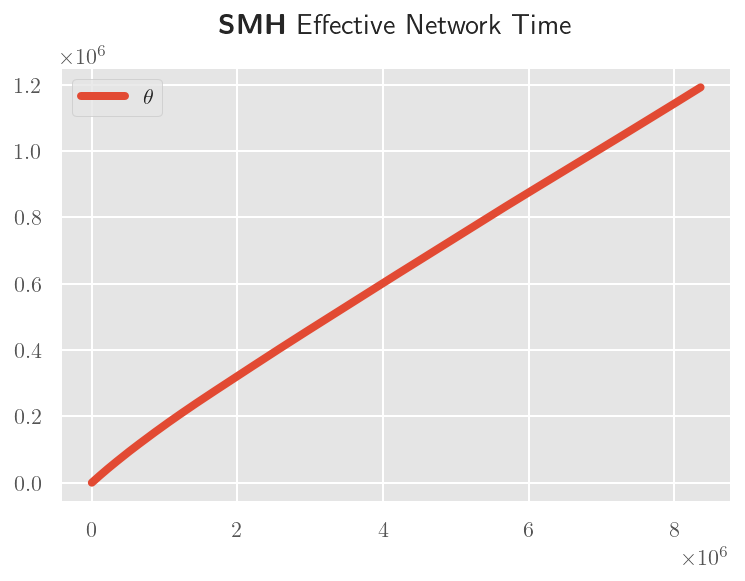

In [306]:
mask = supply.date < datetime.datetime(2101, 1, 1)
plot_theta(supply[mask])

<module 'matplotlib.pyplot' from '/home/lane/.local/share/virtualenvs/crypto-monetary-base-xxmj4jsc/lib/python3.8/site-packages/matplotlib/pyplot.py'>

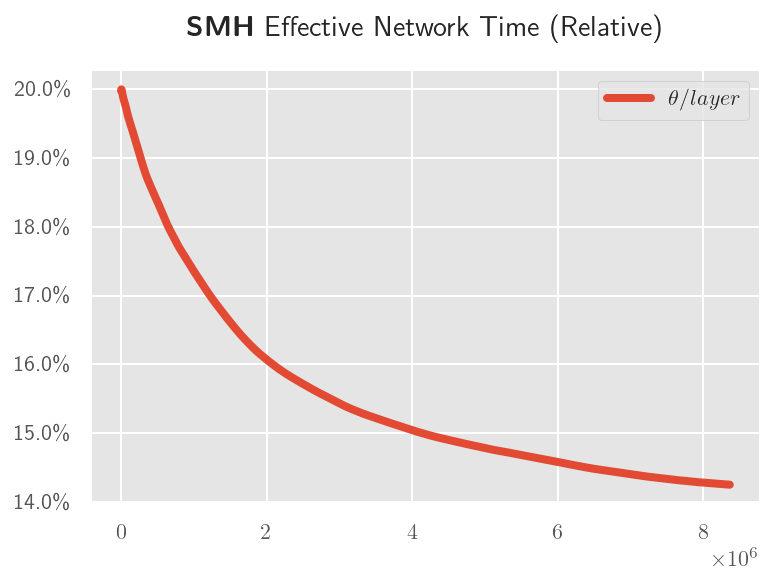

In [307]:
plot_theta(supply[mask], plot_pct=True)

<module 'matplotlib.pyplot' from '/home/lane/.local/share/virtualenvs/crypto-monetary-base-xxmj4jsc/lib/python3.8/site-packages/matplotlib/pyplot.py'>

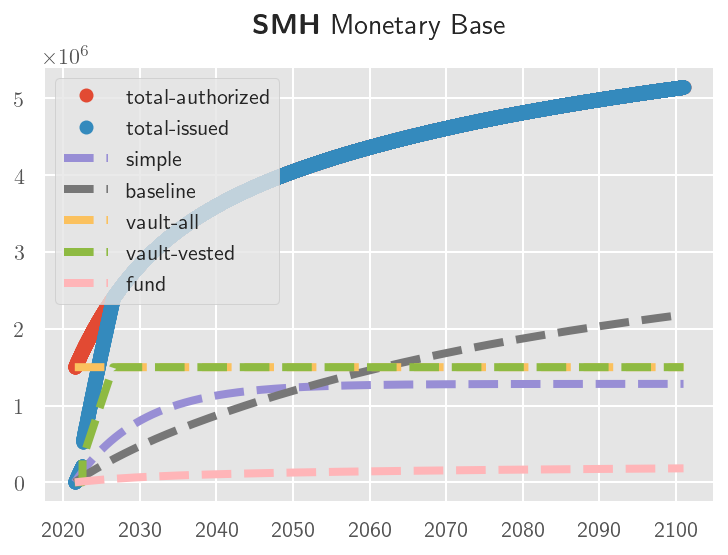

In [308]:
plot_smh_supply_curve_3(supply[mask])

<module 'matplotlib.pyplot' from '/home/lane/.local/share/virtualenvs/crypto-monetary-base-xxmj4jsc/lib/python3.8/site-packages/matplotlib/pyplot.py'>

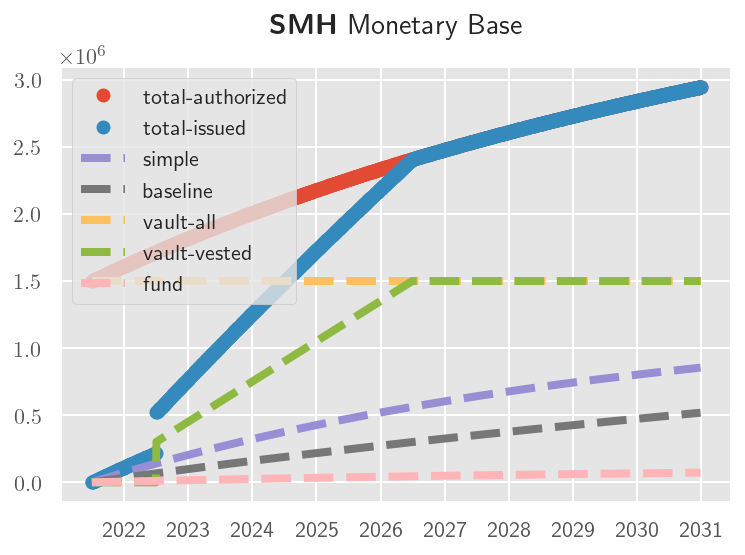

In [309]:
mask = supply.date < datetime.datetime(2031, 1, 1)
plot_smh_supply_curve_3(supply[mask])

<module 'matplotlib.pyplot' from '/home/lane/.local/share/virtualenvs/crypto-monetary-base-xxmj4jsc/lib/python3.8/site-packages/matplotlib/pyplot.py'>

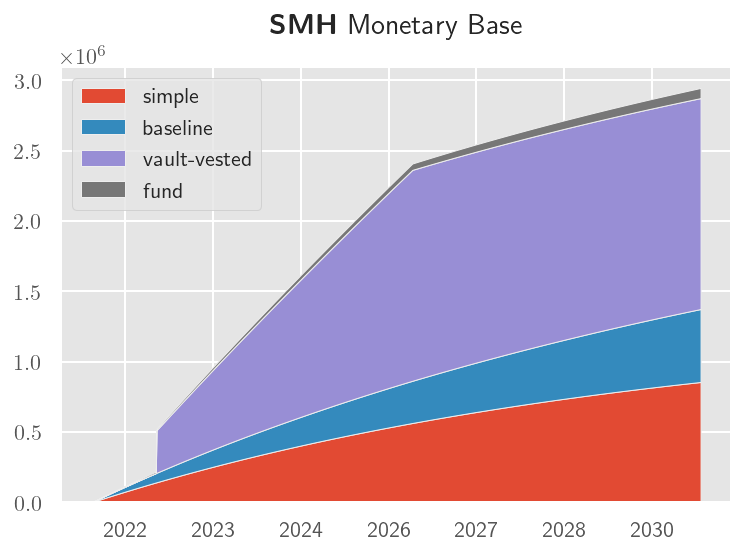

In [310]:
plot_smh_supply_curve_stackplot_3(supply[mask])

## Standardize Time Series

In [189]:
weekly_supply = cmb.transform_supply(supply, COIN_SYMBOL, freq='weekly')

display(weekly_supply.head())
display(weekly_supply.tail())

Wrote 6224 lines to file ../output-data/SMH_weekly.csv


,coin,layer,simple,baseline,vault1,vault2,comfund,simple_pct,baseline_pct,vault1_pct,vault2_pct,comfund_pct,total_authorized,total_issued,total_authorized_pct,total_issued_pct,date
0,SMH,1,1.408473,0.000000,1500000,0.0,0.074130,0.000110,0.000000,100.0,0.0,0.000033,1.500001e+06,1.482604,25.005033,0.000025,2021-07-01
1,SMH,2001,2815.262247,1319.916947,1500000,0.0,217.641010,0.219514,0.044124,100.0,0.0,0.096755,1.504353e+06,4352.820204,25.077570,0.072562,2021-07-01
2,SMH,4001,5622.942311,2642.956297,1500000,0.0,435.047295,0.438437,0.088353,100.0,0.0,0.193406,1.508701e+06,8700.945903,25.150054,0.145045,2021-07-01
3,SMH,6001,8424.462212,3978.989642,1500000,0.0,652.813255,0.656879,0.133016,100.0,0.0,0.290217,1.513056e+06,13056.265109,25.222657,0.217648,2021-07-01
4,SMH,8001,11219.835465,5327.328786,1500000,0.0,870.903382,0.874842,0.178091,100.0,0.0,0.387172,1.517418e+06,17418.067633,25.295368,0.290359,2021-07-01


,coin,layer,simple,baseline,vault1,vault2,comfund,simple_pct,baseline_pct,vault1_pct,vault2_pct,comfund_pct,total_authorized,total_issued,total_authorized_pct,total_issued_pct,date
6219,SMH,12537001,1.282499e+06,2.991354e+06,1500000,1500000.0,224939.603150,99.999999,99.999807,100.0,100.0,99.999865,5.998792e+06,5.998792e+06,99.999899,99.999899,2140-09-01
6220,SMH,12539001,1.282499e+06,2.991355e+06,1500000,1500000.0,224939.679473,99.999999,99.999856,100.0,100.0,99.999899,5.998794e+06,5.998794e+06,99.999924,99.999924,2140-09-01
6221,SMH,12541001,1.282499e+06,2.991357e+06,1500000,1500000.0,224939.755603,100.000000,99.999904,100.0,100.0,99.999933,5.998795e+06,5.998795e+06,99.999950,99.999950,2140-09-01
6222,SMH,12543001,1.282499e+06,2.991358e+06,1500000,1500000.0,224939.831462,100.000000,99.999952,100.0,100.0,99.999966,5.998797e+06,5.998797e+06,99.999975,99.999975,2140-09-01
6223,SMH,12545001,1.282499e+06,2.991360e+06,1500000,1500000.0,224939.906912,100.000000,100.000000,100.0,100.0,100.000000,5.998798e+06,5.998798e+06,100.000000,100.000000,2140-10-01


In [190]:
monthly_supply = cmb.transform_supply(supply, COIN_SYMBOL, freq='monthly')

display(monthly_supply.head())
display(monthly_supply.tail())

Wrote 1432 lines to file ../output-data/SMH_monthly.csv


,coin,layer,simple,baseline,vault1,vault2,comfund,simple_pct,baseline_pct,vault1_pct,vault2_pct,comfund_pct,total_authorized,total_issued,total_authorized_pct,total_issued_pct,date
0,SMH,1,1.408473,0.000000,1500000,0.0,0.074130,0.000110,0.000000,100.0,0.0,0.000033,1.500001e+06,1.482604,25.005033,0.000025,2021-07-01
1,SMH,9001,12615.221314,6005.553582,1500000,0.0,980.040784,0.983644,0.200763,100.0,0.0,0.435690,1.519601e+06,19600.815680,25.331754,0.326746,2021-08-01
2,SMH,18001,25104.972985,12172.448050,1500000,0.0,1961.969528,1.957505,0.406920,100.0,0.0,0.872219,1.539239e+06,39239.390564,25.659130,0.654121,2021-09-01
3,SMH,27001,37471.883672,18428.635678,1500000,0.0,2942.132597,2.921787,0.616062,100.0,0.0,1.307964,1.558843e+06,58842.651947,25.985916,0.980907,2021-10-01
4,SMH,36001,49717.161557,24777.037997,1500000,0.0,3920.747345,3.876586,0.828287,100.0,0.0,1.743020,1.578415e+06,78414.946898,26.312186,1.307178,2021-11-01


,coin,layer,simple,baseline,vault1,vault2,comfund,simple_pct,baseline_pct,vault1_pct,vault2_pct,comfund_pct,total_authorized,total_issued,total_authorized_pct,total_issued_pct,date
1427,SMH,12509001,1.282499e+06,2.991333e+06,1500000,1500000.0,224938.524527,99.999996,99.999124,100.0,100.0,99.999385,5.998770e+06,5.998770e+06,99.999539,99.999539,2140-06-01
1428,SMH,12518001,1.282499e+06,2.991340e+06,1500000,1500000.0,224938.873339,99.999997,99.999345,100.0,100.0,99.999541,5.998777e+06,5.998777e+06,99.999655,99.999655,2140-07-01
1429,SMH,12527001,1.282499e+06,2.991347e+06,1500000,1500000.0,224939.220109,99.999998,99.999565,100.0,100.0,99.999695,5.998784e+06,5.998784e+06,99.999771,99.999771,2140-08-01
1430,SMH,12536001,1.282499e+06,2.991353e+06,1500000,1500000.0,224939.564921,99.999999,99.999783,100.0,100.0,99.999848,5.998791e+06,5.998791e+06,99.999886,99.999886,2140-09-01
1431,SMH,12545001,1.282499e+06,2.991360e+06,1500000,1500000.0,224939.906912,100.000000,100.000000,100.0,100.0,100.000000,5.998798e+06,5.998798e+06,100.000000,100.000000,2140-10-01


In [191]:
yearly_supply = cmb.transform_supply(supply, COIN_SYMBOL, freq='yearly')

display(yearly_supply.head())
display(yearly_supply.tail())

Wrote 120 lines to file ../output-data/SMH_yearly.csv


,coin,layer,simple,baseline,vault1,vault2,comfund,simple_pct,baseline_pct,vault1_pct,vault2_pct,comfund_pct,total_authorized,total_issued,total_authorized_pct,total_issued_pct,date
0,SMH,1,1.408473,0.000000,1500000,0.000000e+00,0.074130,0.000110,0.000000,100.0,0.000000,0.000033,1.500001e+06,1.482604e+00,25.005033,0.000025,2021-07-01
1,SMH,53001,72519.490395,37115.165433,1500000,0.000000e+00,5770.245044,5.654547,1.240746,100.0,0.000000,2.565238,1.615405e+06,1.154049e+05,26.928809,1.923800,2022-01-01
2,SMH,159001,205486.044904,122440.356491,1500000,4.534565e+05,17259.284284,16.022320,4.093134,100.0,30.230436,7.672842,1.845186e+06,7.986422e+05,30.759256,13.313371,2023-01-01
3,SMH,264001,322787.304988,224101.414154,1500000,7.529090e+05,28783.616797,25.168627,7.491624,100.0,50.193931,12.796136,2.075672e+06,1.328581e+06,34.601470,22.147458,2024-01-01
4,SMH,369001,427312.885098,339226.669332,1500000,1.052361e+06,40344.187075,33.318778,11.340217,100.0,70.157426,17.935540,2.306884e+06,1.859245e+06,38.455765,30.993627,2025-01-01


,coin,layer,simple,baseline,vault1,vault2,comfund,simple_pct,baseline_pct,vault1_pct,vault2_pct,comfund_pct,total_authorized,total_issued,total_authorized_pct,total_issued_pct,date
115,SMH,12045001,1.282498e+06,2.990921e+06,1500000,1500000.0,224916.764954,99.999924,99.985334,100.0,100.0,99.989712,5.998335e+06,5.998335e+06,99.992284,99.992284,2136-01-01
116,SMH,12150001,1.282498e+06,2.991026e+06,1500000,1500000.0,224922.315358,99.999944,99.988851,100.0,100.0,99.992179,5.998446e+06,5.998446e+06,99.994135,99.994135,2137-01-01
117,SMH,12255001,1.282498e+06,2.991126e+06,1500000,1500000.0,224927.606034,99.999961,99.992204,100.0,100.0,99.994531,5.998552e+06,5.998552e+06,99.995899,99.995899,2138-01-01
118,SMH,12361001,1.282498e+06,2.991219e+06,1500000,1500000.0,224932.498838,99.999977,99.995305,100.0,100.0,99.996707,5.998650e+06,5.998650e+06,99.997530,99.997530,2139-01-01
119,SMH,12466001,1.282499e+06,2.991301e+06,1500000,1500000.0,224936.840521,99.999991,99.998056,100.0,100.0,99.998637,5.998737e+06,5.998737e+06,99.998978,99.998978,2140-01-01
